# Remake Figure 1

Author: Jacob Parres-Gold (jparresau@caltech.edu)

Last Revised: 20241201

This notebook is designed to reproduce figures from the paper using the archived data folder. Each section should be possible to run independently.

Note that this notebook is primarily intended for users who wish to replot the existing data in different ways; it does not include code for the analysis itself.

In [1]:
import importlib
import itertools
import math
import numpy as np
import os
import pandas as pd
import pathlib
import scipy.stats
import sys
import time

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [2]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
from dimer_network_utilities import *

In [ ]:
# Define directory of the archived data folder parresgold_2023_dimer_networks_data
load_dir = str(pathlib.Path('E:\\','parresgold_2023_dimer_networks','parresgold_2023_dimer_networks_data'))

In [4]:
# Define directory to save to
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [5]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [6]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

C:\Users\jacob\AppData\Local\Temp\ipykernel_38444\3780498324.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


## Figure 1C

Expression levels of nuclear receptor proteins in both Leydig cells and late spermatids.

The data was obtained from the [Human Protein Atlas](https://www.proteinatlas.org/), specifically from [this site](https://www.proteinatlas.org/about/download) under "RNA single cell type data." Data was only taken from the relevant nuclear receptors - 
* Estrogen Receptor alpha - ESR1 (ENSG00000091831)
* Androgen Receptor - AR (ENSG00000169083)
* Glucocorticoid Receptor - NR3C1 (ENSG00000113580)
* Estrogen Receptor beta - ESR2 (ENSG00000140009)
* SHP - NR0B2 (ENSG00000131910)
* DAX1 - NR0B1 (ENSG00000169297)

In [7]:
NRs_of_interest = ['ESR1','AR','NR3C1','ESR2','NR0B2','NR0B1']
NRs_of_interest_common = ['ERα','AR','GR','ERβ','SHP','DAX1']

### Convert Protein Atlas to NR Expression Matrix

In [ ]:
human_protein_atlas_expression = pd.read_csv(pathlib.Path(load_dir,'human_protein_atlas_expression.tsv'), sep="\t",header=0)
human_protein_atlas_expression.head()

In [84]:
# Filter for NRs of interest
NR_expression_df = human_protein_atlas_expression[human_protein_atlas_expression['Gene name'].isin(NRs_of_interest)]

In [87]:
celltypes_human = np.array(NR_expression_df['Cell type'].unique())
print("{} annotated cell types".format(len(celltypes_human)))

79 annotated cell types


In [105]:
NR_human_expression_matrix_TPM = np.ones((len(celltypes_human),len(NRs_of_interest)))

for cell_i in range(len(celltypes_human)):
    for gene_i in range(len(NRs_of_interest)):
        NR_human_expression_matrix_TPM[cell_i, gene_i] = NR_expression_df[(NR_expression_df['Gene name']==NRs_of_interest[gene_i])&\
                                                                            (NR_expression_df['Cell type']==celltypes_human[cell_i])]['nTPM'].values[0]

In [119]:
NR_human_expression_matrix_TPM_df = pd.DataFrame(NR_human_expression_matrix_TPM,columns=NRs_of_interest,index=celltypes_human)
NR_human_expression_matrix_TPM_df.reset_index(inplace=True)
NR_human_expression_matrix_TPM_df.rename(columns={'index':'Cell type'},inplace=True)
NR_human_expression_matrix_TPM_df.to_csv(pathlib.Path(out_dir,'NR_human_expression_matrix.csv'))

### Plot

In [8]:
NR_human_expression_matrix_TPM_df = pd.read_csv(pathlib.Path(load_dir,'NR_human_expression_matrix.csv'),index_col=0)
NR_human_expression_matrix_TPM_df.head()

,Cell type,ESR1,AR,NR3C1,ESR2,NR0B2,NR0B1
0,Adipocytes,1.1,3.1,147.5,0.9,0.0,0.0
1,Alveolar cells type 1,0.3,0.6,94.1,0.2,1.9,0.2
2,Alveolar cells type 2,0.3,4.3,79.4,0.1,13.4,0.0
3,Astrocytes,1.3,27.5,69.0,6.6,0.0,0.0
4,B-cells,1.5,0.8,120.6,5.3,0.0,0.0


In [9]:
celltypes_to_plot = [
    'Leydig cells',
    'Late spermatids'
] 

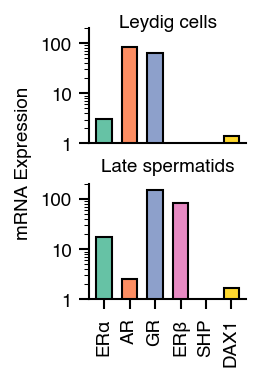

In [10]:
save = True

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(1.35,2.35),sharex=False,sharey=True,gridspec_kw={'hspace':0.35})

cmap = plt.get_cmap('Set2')

for celltype_i, celltype in enumerate(celltypes_to_plot):
    NR_expression_temp = NR_human_expression_matrix_TPM_df[NR_human_expression_matrix_TPM_df['Cell type']==celltype].values[0][1:]
    axs[celltype_i].bar(x=list(range(len(NR_human_expression_matrix_TPM_df.columns)-1)),height=NR_expression_temp,\
                width=0.6,color=[cmap(x) for x in range(len(NRs_of_interest))],\
                edgecolor='black',linewidth=1)
    axs[celltype_i].set_yscale('log')
    axs[celltype_i].set_ylim([1,200])
    if celltype_i==0:
        axs[celltype_i].set_title(celltype,y=0.9)
    else:
        axs[celltype_i].set_title(celltype,y=1)
    if celltype_i==len(celltypes_to_plot)-1:
        axs[celltype_i].set_xticks(list(range(len(NRs_of_interest))),NRs_of_interest_common,rotation=90,va='top')
    else:
        axs[celltype_i].set_xticks([],[])
    axs[celltype_i].set_yticks([1,10,100],['1','10','100'])
    set_spine_linewidth(axs[celltype_i],1)
    axs[celltype_i].spines['top'].set_visible(False)
    axs[celltype_i].spines['right'].set_visible(False)
    # Customize the major ticks
    axs[celltype_i].tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

    # Customize the minor ticks
    axs[celltype_i].tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

fig.supylabel('mRNA Expression',x=-0.2,y=0.5,ha='center',va='center',rotation=90,fontsize=9)

if save:
    filename = f'Fig1C_nuclear_receptor_expression'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Figure 1D

In [7]:
m = 3

# Affinities
K = {
    'K11': 1e4,
    'K12': 1e2,
    'K13': 1e-4,
    # 'K14': 1e-10,
    # 'K15': 1e-10,
    'K22': 1e0,
    'K23': 1e-10,
    'K33': 1e-10,
    # 'K24': 1e-10,
    # 'K25': 1e-10,
    # 'K33': 1e10,
    # 'K34': 1e-10,
    # 'K35': 1e-10,
    # 'K44': 1e-10,
    # 'K45': 1e-10,
    # 'K55': 1e-10,
}

# Accessory expression levels
A = {
    'M2':1e-3,
    'M3':1e3,
    # 'M4':1e0,
    # 'M5':1e0,
}

param_sets = np.array([list(K.values())+list(A.values())])

dimer_of_interest = make_nXn_species_names(m).index('D_2_2') - m # Index of dimer to use as output (D_1_1 = index 0)

In [8]:
save = True

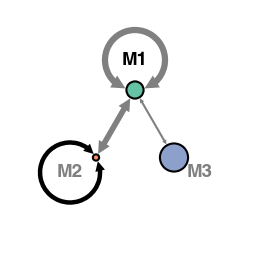

In [149]:
fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=1, # Number of inputs
                                        param_sets=param_sets, # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[dimer_of_interest]]), # Index of output dimer
                                        input_node_values=np.array([0]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.3, # Radius of nodes around center
                                        r_loop = 0.2, # Radius of loops around nodes 
                                        node_scales = [-3,3,4,14.5], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-4,3,1,3], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='Set2', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='gray',
                                        upscale_arrowhead=1.1,
                                        node_edge_width=1,
)

fig.set_dpi(300)

if save:
    filename = f'Fig1D_schematic'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',pad_inches=0,transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight',pad_inches=0)

## Figure 1E

### Interaction 1

In [7]:
m = 6
name = 'intxns_1'

# Affinities
K = {
    'K11': 1e-10,
    'K12': 1e-10,
    'K13': 1e-10,
    'K14': 1e-10,
    'K15': 1e0,
    'K16': 1e0,
    'K22': 1e-10,
    'K23': 1e-10,
    'K24': 1e-10,
    'K25': 1e-3,
    'K26': 1e-10,
    'K33': 1e2,
    'K34': 1e-1,
    'K35': 1e0,
    'K36': 1e-1,
    'K44': 1e-10,
    'K45': 1e-3,
    'K46': 1e-3,
    'K55': 1e-10,
    'K56': 1e-10,
    'K66': 1e-10,
}


# Accessory expression levels
A = {
    'M2':1e-1,
    'M3':1e-1,
    'M4':1e-1,
    'M5':1e-1,
    'M6':1e-1,
}
input_log_value = -1

param_sets = np.array([list(K.values())+list(A.values())])

In [11]:
# Accessory expression levels

name = 'accessories_1'
A = {
    'M2':1e3,
    'M3':1e-3,
    'M4':1e2,
    'M5':1e-1,
    'M6':1e-3,
}

param_sets = np.array([list(K.values())+list(A.values())])

dimer_of_interest = make_nXn_species_names(m).index('D_3_6') - m # Index of dimer to use as output (D_1_1 = index 0)

### Interactions 2

In [13]:
m = 6
name = 'intxns_2'

# Affinities
K = {
    'K11': 1e-10,
    'K12': 1e-2,
    'K13': 1e-10,
    'K14': 1e-10,
    'K15': 1e-10,
    'K16': 1e-10,
    'K22': 1e-10,
    'K23': 1e-10,
    'K24': 1e0,
    'K25': 1e-10,
    'K26': 1e2,
    'K33': 1e-10,
    'K34': 1e-1,
    'K35': 1e-10,
    'K36': 1e-2,
    'K44': 1e-10,
    'K45': 1e-10,
    'K46': 1e-10,
    'K55': 1e0,
    'K56': 1e1,
    'K66': 1e-10,
}

# Accessory expression levels
A = {
    'M2':1e-1,
    'M3':1e-1,
    'M4':1e-1,
    'M5':1e-1,
    'M6':1e-1,
}

input_log_value = -1

param_sets = np.array([list(K.values())+list(A.values())])

In [24]:
dimer_of_interest = make_nXn_species_names(m).index('D_3_6') - m

In [24]:
# Accessory expression levels

name = 'accessories_2a'
A = {
    'M2':1e3,
    'M3':1e-3,
    'M4':1e3,
    'M5':1e-3,
    'M6':1e2,
}

param_sets = np.array([list(K.values())+list(A.values())])

dimer_of_interest = make_nXn_species_names(m).index('D_3_6') - m # Index of dimer to use as output (D_1_1 = index 0)

In [26]:
# Accessory expression levels

name = 'accessories_2b'
A = {
    'M2':1e-1,
    'M3':1e0,
    'M4':1e-2,
    'M5':1e3,
    'M6':1e-3,
}

param_sets = np.array([list(K.values())+list(A.values())])

dimer_of_interest = make_nXn_species_names(m).index('D_3_6') - m # Index of dimer to use as output (D_1_1 = index 0)

### Plot

In [8]:
save = True

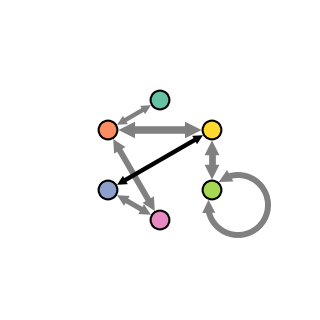

In [25]:
fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=1, # Number of inputs
                                        param_sets=param_sets, # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[dimer_of_interest]]), # Index of output dimer
                                        input_node_values=np.array([input_log_value]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.3, # Radius of nodes around center
                                        r_loop = 0.15, # Radius of loops around nodes 
                                        node_scales = [-3,3,4,14.5], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-4,3,1,3], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='Set2', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='gray',
                                        labels=False,
                                        upscale_arrowhead=1.1,
                                        node_edge_width=0.75,
)

fig.set_dpi(200)

if save:
    # filename = f'Fig1E_{name}'
    filename = 'Fig1E_schematic_uniform_expression'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',pad_inches=0,transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight',pad_inches=0)

## Figure 1F

### m=3 Network

In [402]:
m = 3
name = '3M'

# Affinities
K = {
    'K11': 1e-10,
    'K12': 1e0,
    'K13': 1e-3,
    'K22': 1e-10,
    'K23': 1e3,
    'K33': 1e0,
}

# Accessory expression levels
A = {
    'M2':1e0,
    'M3':1e0,
}

param_sets = np.array([list(K.values())+list(A.values())])

dimer_of_interest1 = make_nXn_species_names(m).index('D_1_1') - m # Index of dimer to use as output (D_1_1 = index 0)

In [403]:
save = True

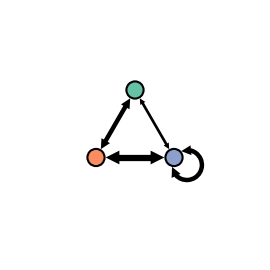

In [406]:
fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=1, # Number of inputs
                                        param_sets=param_sets, # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[dimer_of_interest]]), # Index of output dimer
                                        input_node_values=np.array([0]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.15, # Radius of nodes around center
                                        r_loop = 0.05, # Radius of loops around nodes 
                                        node_scales = [-3,3,2,7.25], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-4,3,0.5,1.5], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='Set2', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='k',
                                        labels=False,
                                        upscale_arrowhead=1.1,
                                        node_edge_width=0.5,
)

fig.set_dpi(300)

if save:
    filename = f'Fig1F_{name}'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',pad_inches=0,transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight',pad_inches=0)

### m=12 Network

In [407]:
m = 12
name = '12M'

rng = np.random.default_rng()

# Affinities
num_dimers = int(num_combos_with_replacement(m,2))
# K = 10**rng.uniform(-4,2,size=num_dimers)
# K[rng.choice(range(num_dimers),size=int(0.8*num_dimers),replace=False)] = 1e-10

K = np.array([1e-10, 2.61231469e-02, 1e-10, 1e-10,
       1e-10, 1e-10, 6.07017213e-1, 1e-10,
       1e-10, 1e-10, 1e-10, 1e-10,
       1e-10, 1e-10, 1e-10, 1e-10,
       1e-10, 1e-10, 1e-10, 1.43199650e+00,
       1e-10, 1e-10, 1e-10, 1e-10,
       1e-10, 1e-10, 6.28991029e-02, 5.43936229e-02,
       3.38198198e-03, 1e-10, 1.74561245e-02, 1e-10,
       1e-10, 1e-10, 6.67792875e-03, 8.74436415e-3,
       1e-10, 1e-10, 1e-10, 1e-10,
       1e-10, 1e-10, 1e-10, 1e-10,
       1e-10, 1e-10, 1e-10, 1e-10,
       1.94994400e-04, 1e-10, 4.12277754e-1, 1e-10,
       1e-10, 1e-10, 1e-10, 1e-10,
       1.79689251e-02, 1e-10, 1e-10, 1e-10,
       1e-10, 1e-10, 1e-10, 9.89318853e-04,
       1e-10, 8.64521363e-02, 2.38332373e-1, 1e-10,
       1e-10, 5.04589814e-03, 1e-10, 1e-10,
       1e-10, 1e-10, 1e-10, 1e-10,
       1e-10, 1e-10])

In [408]:
# Accessory expression levels
A = 10**rng.uniform(-3,3,size=(m-1,))

param_sets = np.expand_dims(np.hstack((K,A)),axis=0)

dimer_of_interest1 = make_nXn_species_names(m).index('D_1_1') - m # Index of dimer to use as output (D_1_1 = index 0)

In [409]:
save = True

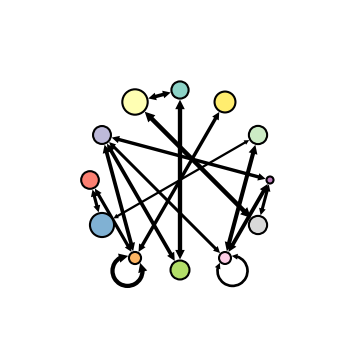

In [411]:
fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=1, # Number of inputs
                                        param_sets=param_sets, # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[dimer_of_interest]]), # Index of output dimer
                                        input_node_values=np.array([0]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.3, # Radius of nodes around center
                                        r_loop = 0.05, # Radius of loops around nodes 
                                        node_scales = [-3,3,2,7.25], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-4,3,0.5,1.5], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='Set3', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='k',
                                        labels=False,
                                        upscale_arrowhead=1.1,
                                        node_edge_width=0.5,
)

fig.set_dpi(300)

if save:
    filename = f'Fig1F_{name}'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',pad_inches=0,transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight',pad_inches=0)

### Sparse m=8 Network

In [412]:
m = 8
name = '8M_sparse'

rng = np.random.default_rng()

# Affinities
num_dimers = int(num_combos_with_replacement(m,2))
dimer_names = make_nXn_species_names(m)[m::]
homodimer_ids = [i for i, dimer_name in enumerate(dimer_names) if dimer_name.split('_')[1]==dimer_name.split('_')[2]]
heterodimer_ids = [i for i, dimer_name in enumerate(dimer_names) if dimer_name.split('_')[1]!=dimer_name.split('_')[2]]
# K = 10**rng.uniform(-4,2,size=num_dimers)
# K[rng.choice(heterodimer_ids,size=num_combos(m,2)-(m-1),replace=False)] = 1e-10
# K[rng.choice(homodimer_ids,size=m-2,replace=False)] = 1e-10

K = np.array([4.82272932e-02, 1e-10, 1e-10, 1.01525966e-01,
       1e-10, 1e-10, 2.25593223e-1, 1e-10,
       1e-10, 1e-10, 1e-10, 1e-10,
       1e-10, 9.88598001e-1, 1e-10, 1e-10,
       1e-10, 1.54345454e-04, 1e-10, 1e-10,
       6.83877499e-1, 1e-10, 1e-10, 1.53790928e-01,
       1e-10, 1e-10, 1e-10, 1e-10,
       1e-10, 1e-10, 4.22787160e+01, 1e-10,
       1.55744818e+00, 1e-10, 1e-10, 1e-10])

In [413]:
# Accessory expression levels
A = 10**rng.uniform(-3,3,size=(m-1,))

param_sets = np.expand_dims(np.hstack((K,A)),axis=0)

dimer_of_interest1 = make_nXn_species_names(m).index('D_1_1') - m # Index of dimer to use as output (D_1_1 = index 0)

In [414]:
save = True

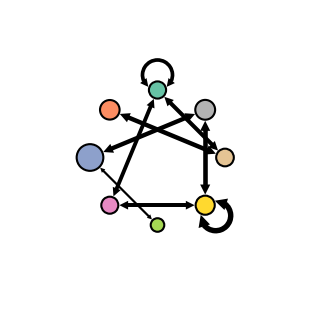

In [418]:
fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=1, # Number of inputs
                                        param_sets=param_sets, # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[dimer_of_interest]]), # Index of output dimer
                                        input_node_values=np.array([0]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.225, # Radius of nodes around center
                                        r_loop = 0.05, # Radius of loops around nodes 
                                        node_scales = [-3,3,2,7.25], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-4,3,0.5,1.5], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='Set2', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='k',
                                        labels=False,
                                        upscale_arrowhead=1.1,
                                        node_edge_width=0.5,
)

fig.set_dpi(300)

if save:
    filename = f'Fig1F_{name}'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',pad_inches=0,transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight',pad_inches=0)

### Dense m=8 Network

In [419]:
m = 8
name = '8M_dense'

rng = np.random.default_rng()

# Affinities
num_dimers = int(num_combos_with_replacement(m,2))
dimer_names = make_nXn_species_names(m)[m::]
# homodimer_ids = [i for i, dimer_name in enumerate(dimer_names) if dimer_name.split('_')[1]==dimer_name.split('_')[2]]
# heterodimer_ids = [i for i, dimer_name in enumerate(dimer_names) if dimer_name.split('_')[1]!=dimer_name.split('_')[2]]
# K = 10**rng.uniform(-4,0,size=num_dimers)
# K[rng.choice(homodimer_ids,size=m-6,replace=False)] = 1e-10

K = np.array([4.93544885e-03, 4.40699962e-01, 6.33636947e-04, 1.19269786e-04,
       1.88337340e-03, 2.73852465e-02, 1.03160450e-02, 1.79349794e-04,
       1.20642486e-03, 2.30426067e-02, 7.79896020e-02, 6.15586177e-03,
       7.16475909e-04, 1.31996958e-01, 2.02752478e-03, 1.43232892e-04,
       5.43896430e-03, 4.42422532e-02, 1.04951871e-01, 2.42451895e-03,
       2.35722215e-01, 2.22450236e-01, 7.65967511e-04, 1.94854976e-01,
       4.46923919e-01, 2.68758780e-02, 7.88771803e-02, 1.00323951e-02,
       7.97356018e-03, 8.80530421e-04, 1.00000000e-10, 9.46728951e-01,
       4.03972354e-04, 4.10489366e-03, 2.88713116e-01, 1e-10])

In [420]:
# Accessory expression levels
# A = 10**rng.uniform(-3,3,size=(m-1,))
A = np.array([1.63940710e-01, 4.75864807e-02, 1.33225641e+01, 1.03651378e-1,
       1.25868222e+00, 1.67212560e+00, 4.04323452e-03])

param_sets = np.expand_dims(np.hstack((K,A)),axis=0)

dimer_of_interest1 = make_nXn_species_names(m).index('D_1_1') - m # Index of dimer to use as output (D_1_1 = index 0)

In [421]:
save = True

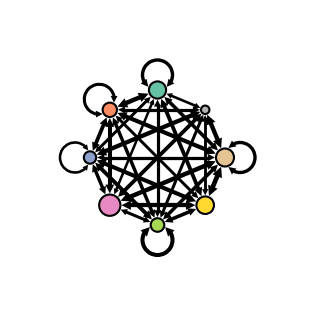

In [425]:
fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=1, # Number of inputs
                                        param_sets=param_sets, # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[dimer_of_interest]]), # Index of output dimer
                                        input_node_values=np.array([0]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.225, # Radius of nodes around center
                                        r_loop = 0.05, # Radius of loops around nodes 
                                        node_scales = [-3,3,2,7.25], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-4,3,0.6,1.5], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='Set2', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='k',
                                        labels=False,
                                        upscale_arrowhead=1.1,
                                        node_edge_width=0.5,
)

fig.set_dpi(300)

if save:
    filename = f'Fig1F_{name}'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',pad_inches=0,transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight',pad_inches=0)